Classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']
Using device: cpu

=== Training Started ===
Epoch [1/30] Train Loss: 1.4804 | Val Loss: 1.0562 | Val Acc: 76.49%
🌟 Best model updated!s: 1.4804 | Val Loss: 1.0562 | Val Acc: 76.49%

Epoch [2/30] Train Loss: 0.6755 | Val Loss: 0.3485 | Val Acc: 92.79%


🌟 Best model updated!s: 0.6755 | Val Loss: 0.3485 | Val Acc: 92.79%



Epoch [3/30] Train Loss: 0.2782 | Val Loss: 0.1690 | Val Acc: 96.24%




🌟 Best model updated!s: 0.2782 | Val Loss: 0.1690 | Val Acc: 96.24%





Epoch [4/30] Train Loss: 0.1681 | Val Loss: 0.1403 | Val Acc: 95.30%






5/30] Train Loss: 0.1259 | Val Loss: 0.0826 | Val Acc: 96.87%







🌟 Best model updated!59 | Val Loss: 0.0826 | Val Acc: 96.87%








Epoch [6/30] Train Loss: 0.1115 | Val Loss: 0.0939 | Val Acc: 96.87%


7/30] Train Loss: 0.0935 | Val Loss: 0.0546 | Val Acc: 97.49%



🌟 Best model updated!35 | Val Loss: 0.0546 | Val Acc: 97.49%




Epoch [8/30] Train Loss:

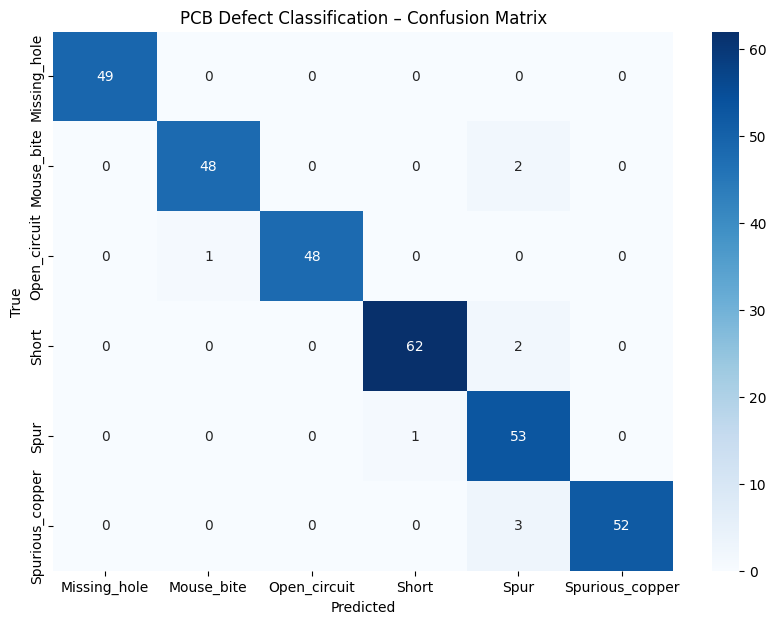


Classification Report:
                 precision    recall  f1-score   support

   Missing_hole       1.00      1.00      1.00        49
     Mouse_bite       0.98      0.96      0.97        50
   Open_circuit       1.00      0.98      0.99        49
          Short       0.98      0.97      0.98        64
           Spur       0.88      0.98      0.93        54
Spurious_copper       1.00      0.95      0.97        55

       accuracy                           0.97       321
      macro avg       0.97      0.97      0.97       321
   weighted avg       0.97      0.97      0.97       321



In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================================
# PATHS
# ================================
DATA_DIR = r"C:\Users\Kandu\OneDrive\Desktop\PCB_DATASET\ROIs"
MODEL_SAVE_PATH = r"C:\Users\Kandu\OneDrive\Desktop\PCB_DATASET\efficientnet_b4_pcb.pth"

# ================================
# HYPERPARAMETERS
# ================================
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
IMG_SIZE = 128
NUM_WORKERS = 4

# ================================
# DATA TRANSFORMS (Augmentation)
# ================================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

# ================================
# DATASETS + LOADERS
# ================================
dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

train_size = int(0.80 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# ================================
# MODEL: EfficientNet-B4
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# ================================
# LOSS + OPTIMIZER
# ================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ================================
# TRAINING LOOP
# ================================
best_val_acc = 0
train_losses, val_losses = [], []

print("\n=== Training Started ===")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_loss = 0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_acc = correct / total * 100

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

    # Save best model (for module 4 & 6)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("🌟 Best model updated!")

print("\nTraining Complete!")

# ================================
# TEST + CONFUSION MATRIX
# ================================
print("\n=== Running Final Test Evaluation ===")
true_labels = []
pred_labels = []

model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Accuracy
test_acc = np.mean(np.array(true_labels) == np.array(pred_labels)) * 100
print(f"\n🔥 Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("PCB Defect Classification – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))
